# Distance trial: EMD, cosine similarity, Pearson's correlation

### On TabulaMuris datasets

In [28]:
import numpy as np
import pandas as pd
import scanpy.api as sc
import anndata
from sklearn.linear_model import LogisticRegression
import pickle
import bbknn
import anndata

from scipy.stats import wasserstein_distance
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import seaborn as sns
from math import factorial


sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)
results_file = '/home/jovyan/notebooks/Tree_of_Cells/lung_facs_trial.h5ad'  # the file that will store the analysis results

scanpy==1.4 anndata==0.6.18 numpy==1.16.2 scipy==1.2.1 pandas==0.24.1 scikit-learn==0.20.3 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [29]:
sc.settings.set_figure_params(dpi=80)

In [30]:
tissues = ['Bladder','Heart','Kidney','Liver','Lung','Mammary','Marrow','Muscle','Spleen','Thymus','Tongue','Trachea']


All analyses are based on only DE genes (FDR < 5%, logFC > 1)

### Distance matrices for all TabulaMuris datasets were calculated using functions in ToC_robustness_subset.ipynb

## 1. EMD (Wasserstein distance)

In [31]:
# Reading distance matrices
all_df_DE_EMD = {}
for tissue in tissues:
    all_df_DE_EMD[tissue+'_SS2'] = pd.read_csv('/home/jovyan/notebooks/Tree_of_Cells/data/EMD_matrix_DE_binned_'+tissue+'_SS2.csv',
                                           index_col=0)
    all_df_DE_EMD[tissue+'_10X'] = pd.read_csv('/home/jovyan/notebooks/Tree_of_Cells/data/EMD_matrix_DE_binned_'+tissue+'_10X.csv',
                                           index_col=0)

In [32]:
EMD_var_DE = {}
for tissue in tissues:
    #print(tissue)
    curr_dimension = all_df_DE_EMD[tissue+'_SS2'].shape[0]
    curr_var = np.zeros((curr_dimension,curr_dimension))
    #print(curr_var)
    for i in range(curr_dimension):
        for j in range(curr_dimension):
            curr_var[i][j] = (all_df_DE_EMD[tissue+'_SS2'][all_df_DE_EMD[tissue+'_SS2'].index[i]][all_df_DE_EMD[tissue+'_SS2'].columns[j]] - all_df_DE_EMD[tissue+'_10X'][all_df_DE_EMD[tissue+'_10X'].index[i]][all_df_DE_EMD[tissue+'_10X'].columns[j]])**2/curr_dimension**2
    EMD_var_DE[tissue] = curr_var.sum()
    #print(curr_var, EMD_var_DE)
EMD_var_DE_df = pd.DataFrame(index=list(EMD_var_DE.keys()))
EMD_var_DE_df['variance'] = list(EMD_var_DE.values())  
EMD_var_DE_df.reset_index(inplace=True)
EMD_var_DE_df.columns = ['tissue','variance']
EMD_var_DE_df['number of cell types'] = EMD_var_DE_df['tissue'].apply(lambda x: len(all_df_DE_EMD[x+'_10X'].columns))

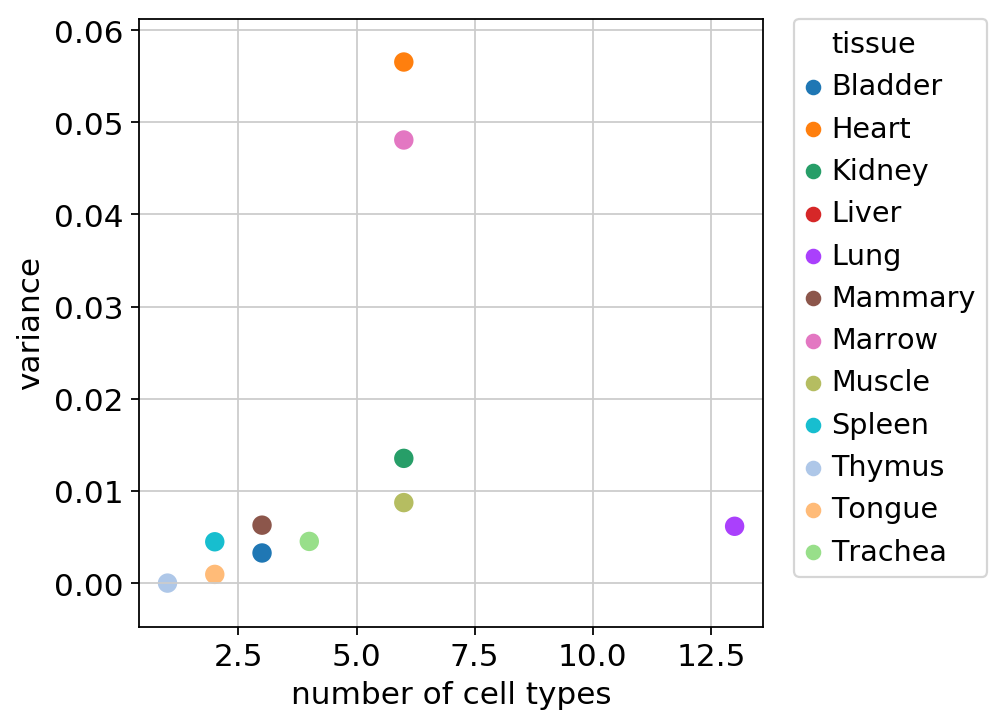

In [33]:
plt.figure(figsize=[5,5])
ax = plt.subplot(111)

sns.scatterplot(x='number of cell types',y='variance',hue='tissue',data=EMD_var_DE_df,s=90)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [34]:
distances_10X_DE_EMD = []
distances_SS2_DE_EMD = []
for tissue in tissues:
    curr_dimension = all_df_DE_EMD[tissue+'_10X'].shape[0] # common for 10X and SS2
    curr_list_10X_DE = (all_df_DE_EMD[tissue+'_10X'].to_numpy()).ravel().tolist()
    curr_list_SS2_DE = (all_df_DE_EMD[tissue+'_SS2'].to_numpy()).ravel().tolist()    
    for j in range(curr_dimension):
        # skipping the diagonal elements, because they are all 0.0 (same cell types)
        distances_10X_DE_EMD.append(curr_list_10X_DE[j*curr_dimension+j+1:j*curr_dimension+curr_dimension])
        distances_SS2_DE_EMD.append(curr_list_SS2_DE[j*curr_dimension+j+1:j*curr_dimension+curr_dimension])
# flattening the lists of lists
distances_10X_DE_EMD = [item for sublist in distances_10X_DE_EMD for item in sublist]
distances_SS2_DE_EMD = [item for sublist in distances_SS2_DE_EMD for item in sublist]


In [35]:
distances_df_DE_EMD = pd.DataFrame(data={'distances': distances_10X_DE_EMD+distances_SS2_DE_EMD, 
                                  'scTECH': ['10X']*len(distances_10X_DE_EMD)+['SS2']*len(distances_SS2_DE_EMD)})

In [36]:
# common array of distances for 10X and SS2, EMD
dict_tissue_to_unique_distances_DE_EMD = {}
for tissue in tissues:
    curr_dimension = all_df_DE_EMD[tissue+'_10X'].shape[0] # common for 10X and SS2
    #print(curr_dimension-2)
    if curr_dimension > 1:
        dict_tissue_to_unique_distances_DE_EMD[tissue] = factorial(curr_dimension)/(factorial(2)*factorial(curr_dimension-2))
df_tissue_to_unique_distances_DE_EMD = pd.DataFrame(index=list(dict_tissue_to_unique_distances_DE_EMD.keys()))
df_tissue_to_unique_distances_DE_EMD['unique distances'] = list(dict_tissue_to_unique_distances_DE_EMD.values())
# adding a tissue column
tissue_list_to_add_DE_EMD = [[df_tissue_to_unique_distances_DE_EMD.index[i]]*int(df_tissue_to_unique_distances_DE_EMD['unique distances'][i]) for i in range(len(df_tissue_to_unique_distances_DE_EMD))]
# flattening the list of lists
tissue_list_to_add_DE_EMD = [item for sublist in tissue_list_to_add_DE_EMD for item in sublist]
distances_df_DE_EMD['tissue'] = tissue_list_to_add_DE_EMD*2
distances_coll_DE_EMD = pd.DataFrame(data={'tissue':distances_df_DE_EMD['tissue'][:int(len(distances_df_DE_EMD)/2)],
                                    'distances 10X':distances_10X_DE_EMD,'distances SS2':distances_SS2_DE_EMD})

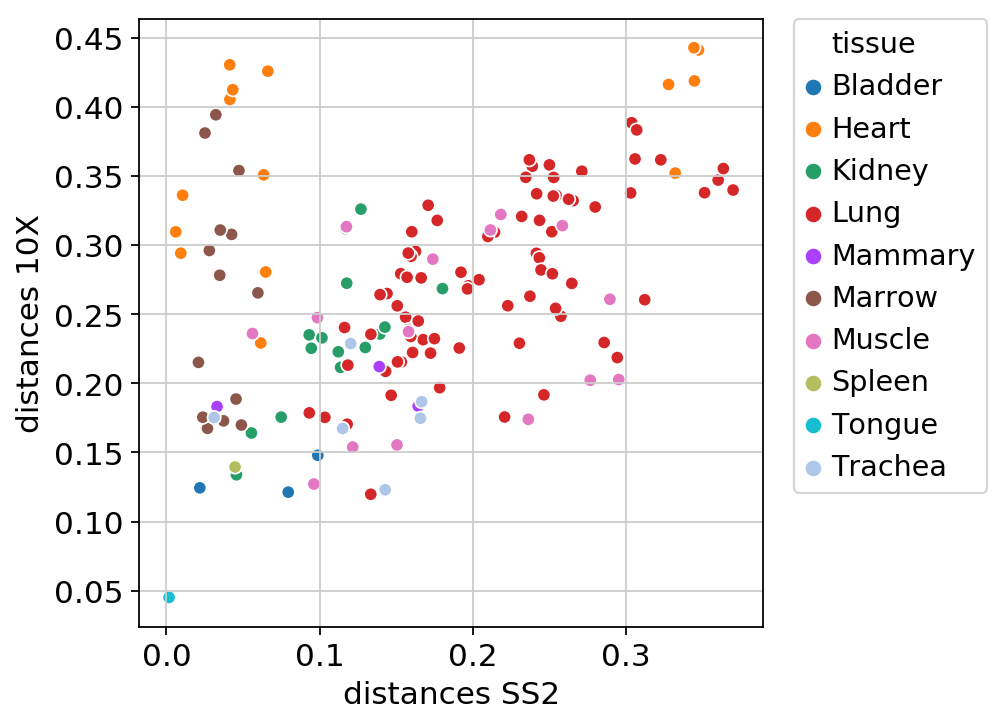

In [37]:
plt.figure(figsize=[5,5])
ax = plt.subplot(111)

sns.scatterplot(x='distances SS2',y='distances 10X',data=distances_coll_DE_EMD,hue='tissue')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [52]:
np.corrcoef(distances_coll_DE_EMD['distances 10X'],distances_coll_DE_EMD['distances SS2'])[0][1]

0.40656559384959357

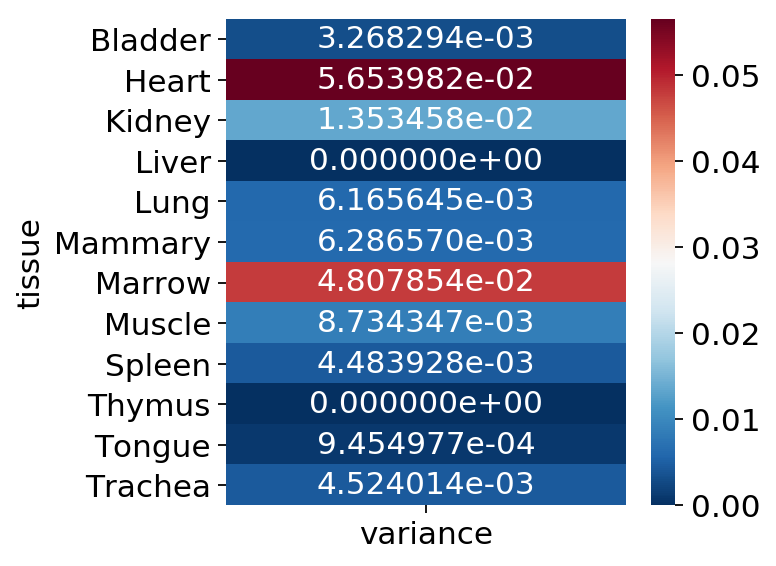

In [17]:
EMD_var_DE_df.drop(['number of cell types'],axis=1,inplace=True)
EMD_var_DE_df.set_index('tissue',inplace=True)
sns.heatmap(EMD_var_DE_df,cmap="RdBu_r",annot=True,fmt="e")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

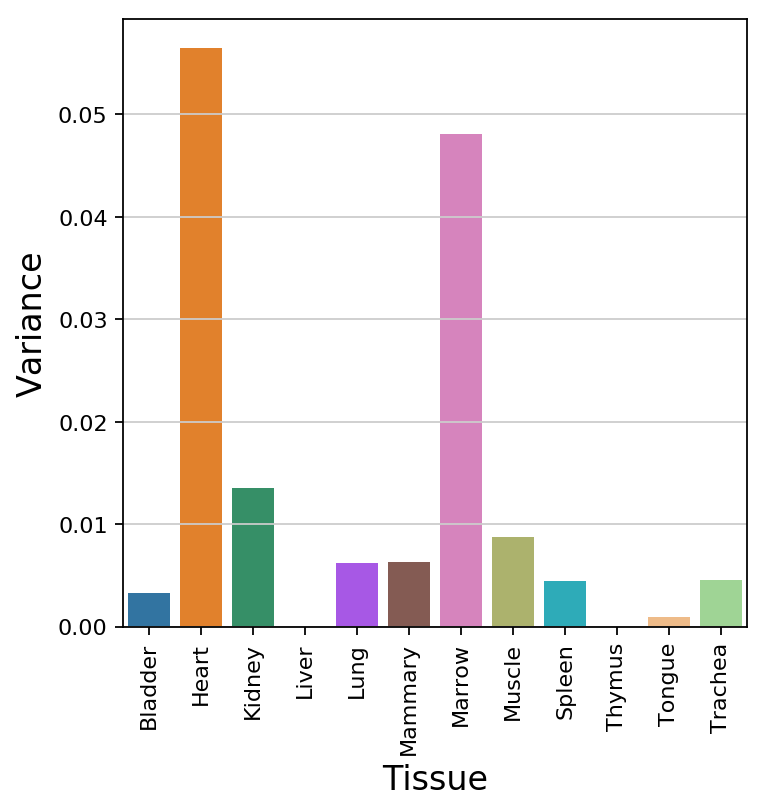

In [39]:
# just a bar chart of variances, EMD
plt.figure(figsize=[5,5])
ax = plt.subplot(111)
sns.barplot(x=list(EMD_var_DE.keys()),y=list(EMD_var_DE.values()))
plt.xlabel('Tissue',fontsize=15)
plt.ylabel('Variance',fontsize=15)
plt.tick_params(labelsize=10)
plt.xticks(rotation='vertical')

## 2. Cosine similarity

In [40]:
# Reading
all_df_DE_cosine = {}
for tissue in tissues:
    all_df_DE_cosine[tissue+'_SS2'] = pd.read_csv('/home/jovyan/notebooks/Tree_of_Cells/data/cosine_matrix_DE_'+tissue+'_SS2.csv',
                                           index_col=0)
    all_df_DE_cosine[tissue+'_10X'] = pd.read_csv('/home/jovyan/notebooks/Tree_of_Cells/data/cosine_matrix_DE_'+tissue+'_10X.csv',
                                           index_col=0)

In [41]:
cosine_var_DE = {}
for tissue in tissues:
    #print(tissue)
    curr_dimension = all_df_DE_cosine[tissue+'_SS2'].shape[0]
    curr_var = np.zeros((curr_dimension,curr_dimension))
    #print(curr_var)
    for i in range(curr_dimension):
        for j in range(curr_dimension):
            curr_var[i][j] = (all_df_DE_cosine[tissue+'_SS2'][all_df_DE_cosine[tissue+'_SS2'].index[i]][all_df_DE_cosine[tissue+'_SS2'].columns[j]] - all_df_DE_cosine[tissue+'_10X'][all_df_DE_cosine[tissue+'_10X'].index[i]][all_df_DE_cosine[tissue+'_10X'].columns[j]])**2/curr_dimension**2
    cosine_var_DE[tissue] = curr_var.sum()
    #print(curr_var, cosine_var_DE)
cosine_var_DE_df = pd.DataFrame(index=list(cosine_var_DE.keys()))
cosine_var_DE_df['variance'] = list(cosine_var_DE.values())  
cosine_var_DE_df.reset_index(inplace=True)
cosine_var_DE_df.columns = ['tissue','variance']
cosine_var_DE_df['number of cell types'] = cosine_var_DE_df['tissue'].apply(lambda x: len(all_df_DE_cosine[x+'_10X'].columns))

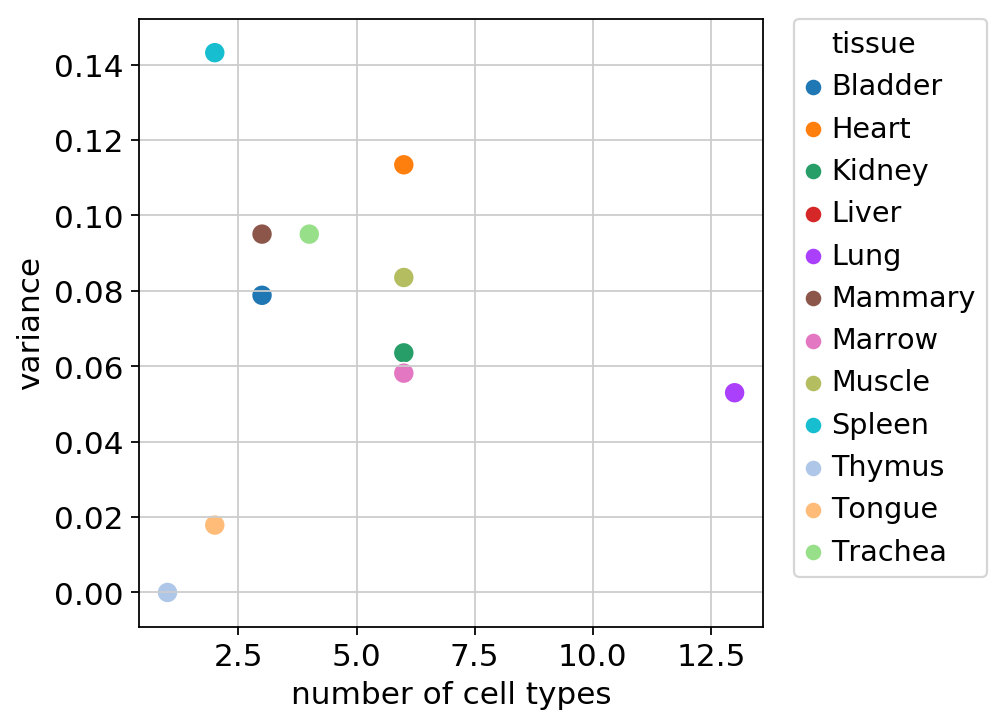

In [42]:
plt.figure(figsize=[5,5])
ax = plt.subplot(111)

sns.scatterplot(x='number of cell types',y='variance',hue='tissue',data=cosine_var_DE_df,s=90)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [43]:
distances_10X_DE_cosine = []
distances_SS2_DE_cosine = []
for tissue in tissues:
    curr_dimension = all_df_DE_cosine[tissue+'_10X'].shape[0] # common for 10X and SS2
    curr_list_10X_DE = (all_df_DE_cosine[tissue+'_10X'].to_numpy()).ravel().tolist()
    curr_list_SS2_DE = (all_df_DE_cosine[tissue+'_SS2'].to_numpy()).ravel().tolist()    
    for j in range(curr_dimension):
        # skipping the diagonal elements, because they are all 0.0 (same cell types)
        distances_10X_DE_cosine.append(curr_list_10X_DE[j*curr_dimension+j+1:j*curr_dimension+curr_dimension])
        distances_SS2_DE_cosine.append(curr_list_SS2_DE[j*curr_dimension+j+1:j*curr_dimension+curr_dimension])
# flattening the lists of lists
distances_10X_DE_cosine = [item for sublist in distances_10X_DE_cosine for item in sublist]
distances_SS2_DE_cosine = [item for sublist in distances_SS2_DE_cosine for item in sublist]
distances_df_DE_cosine = pd.DataFrame(data={'distances': distances_10X_DE_cosine+distances_SS2_DE_cosine, 
                                  'scTECH': ['10X']*len(distances_10X_DE_cosine)+['SS2']*len(distances_SS2_DE_cosine)})

In [44]:
# common array of distances for 10X and SS2, EMD
dict_tissue_to_unique_distances_DE_cosine = {}
for tissue in tissues:
    curr_dimension = all_df_DE_cosine[tissue+'_10X'].shape[0] # common for 10X and SS2
    #print(curr_dimension-2)
    if curr_dimension > 1:
        dict_tissue_to_unique_distances_DE_cosine[tissue] = factorial(curr_dimension)/(factorial(2)*factorial(curr_dimension-2))
df_tissue_to_unique_distances_DE_cosine = pd.DataFrame(index=list(dict_tissue_to_unique_distances_DE_cosine.keys()))
df_tissue_to_unique_distances_DE_cosine['unique distances'] = list(dict_tissue_to_unique_distances_DE_cosine.values())
# adding a tissue column
tissue_list_to_add_DE_cosine = [[df_tissue_to_unique_distances_DE_cosine.index[i]]*int(df_tissue_to_unique_distances_DE_cosine['unique distances'][i]) for i in range(len(df_tissue_to_unique_distances_DE_cosine))]
# flattening the list of lists
tissue_list_to_add_DE_cosine = [item for sublist in tissue_list_to_add_DE_cosine for item in sublist]
distances_df_DE_cosine['tissue'] = tissue_list_to_add_DE_cosine*2
distances_coll_DE_cosine = pd.DataFrame(data={'tissue':distances_df_DE_cosine['tissue'][:int(len(distances_df_DE_cosine)/2)],
                                    'distances 10X':distances_10X_DE_cosine,'distances SS2':distances_SS2_DE_cosine})

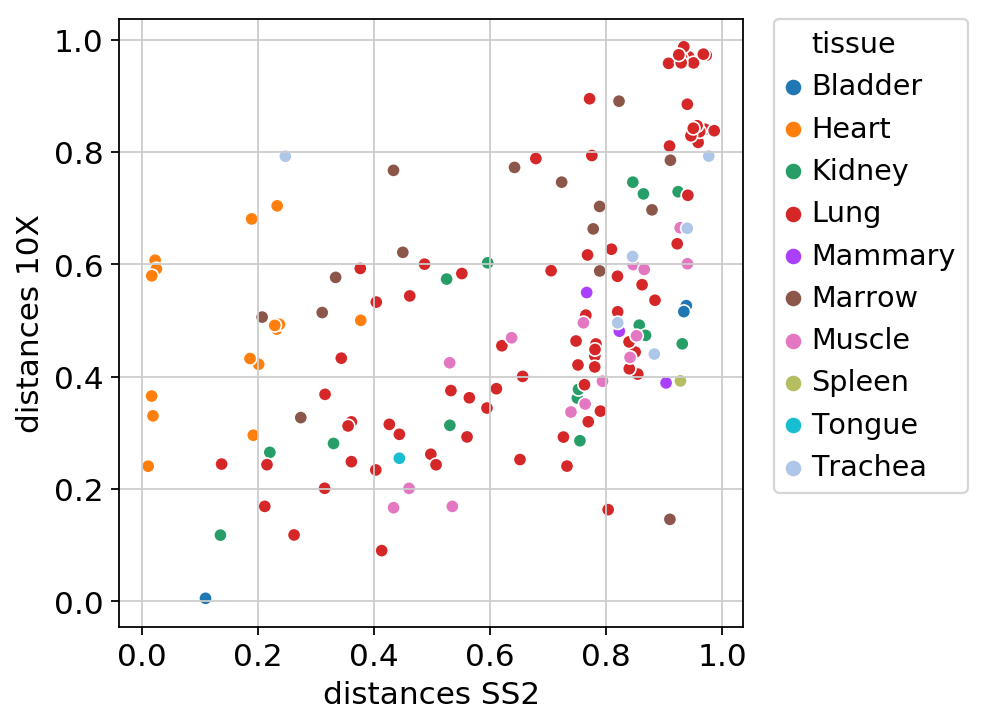

In [45]:
plt.figure(figsize=[5,5])
ax = plt.subplot(111)

sns.scatterplot(x='distances SS2',y='distances 10X',data=distances_coll_DE_cosine,hue='tissue')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [53]:
np.corrcoef(distances_coll_DE_cosine['distances 10X'],distances_coll_DE_cosine['distances SS2'])[0][1]

0.5111107761306909

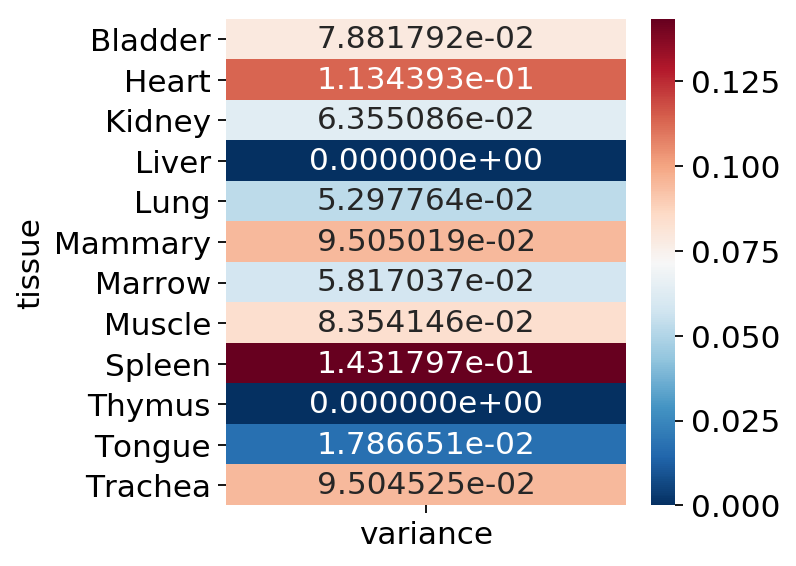

In [27]:
cosine_var_DE_df.drop(['number of cell types'],axis=1,inplace=True)
cosine_var_DE_df.set_index('tissue',inplace=True)
sns.heatmap(cosine_var_DE_df,cmap="RdBu_r",annot=True,fmt="e")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

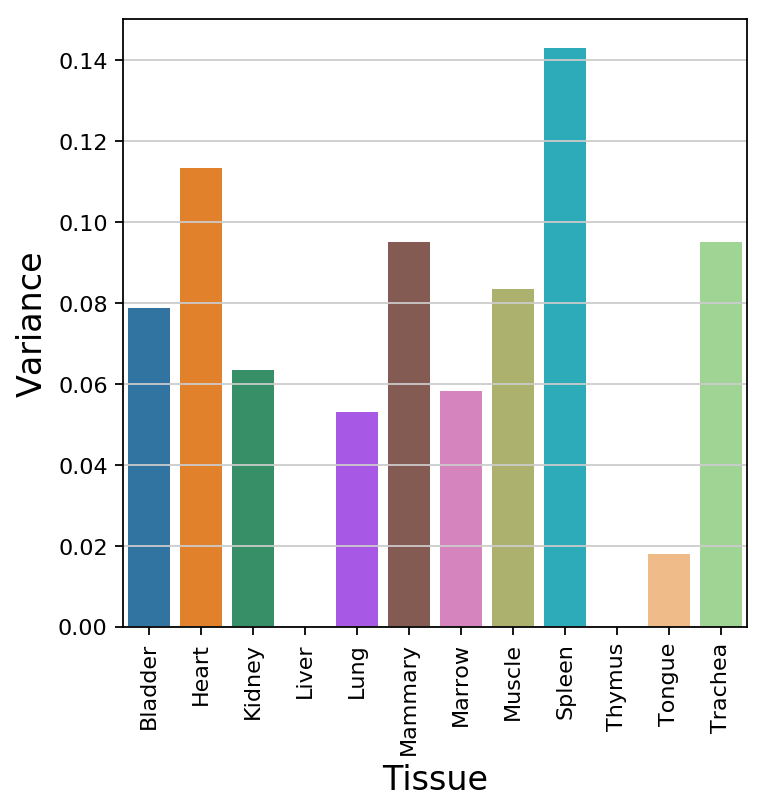

In [47]:
# just a bar chart of variances, EMD
plt.figure(figsize=[5,5])
ax = plt.subplot(111)
sns.barplot(x=list(cosine_var_DE.keys()),y=list(cosine_var_DE.values()))
plt.xlabel('Tissue',fontsize=15)
plt.tick_params(labelsize=10)
plt.ylabel('Variance',fontsize=15)
plt.xticks(rotation='vertical')

## 3. Pearson's correlation

In [48]:
# Reading
all_df_DE_pearson = {}
for tissue in tissues:
    all_df_DE_pearson[tissue+'_SS2'] = pd.read_csv('/home/jovyan/notebooks/Tree_of_Cells/data/pearson_matrix_DE_'+tissue+'_SS2.csv',
                                           index_col=0)
    all_df_DE_pearson[tissue+'_10X'] = pd.read_csv('/home/jovyan/notebooks/Tree_of_Cells/data/pearson_matrix_DE_'+tissue+'_10X.csv',
                                           index_col=0)

In [49]:
pearson_var_DE = {}
for tissue in tissues:
    #print(tissue)
    curr_dimension = all_df_DE_pearson[tissue+'_SS2'].shape[0]
    curr_var = np.zeros((curr_dimension,curr_dimension))
    #print(curr_var)
    for i in range(curr_dimension):
        for j in range(curr_dimension):
            curr_var[i][j] = (all_df_DE_pearson[tissue+'_SS2'][all_df_DE_pearson[tissue+'_SS2'].index[i]][all_df_DE_pearson[tissue+'_SS2'].columns[j]] - all_df_DE_pearson[tissue+'_10X'][all_df_DE_pearson[tissue+'_10X'].index[i]][all_df_DE_pearson[tissue+'_10X'].columns[j]])**2/curr_dimension**2
    pearson_var_DE[tissue] = curr_var.sum()
    #print(curr_var, cosine_var_DE)
pearson_var_DE_df = pd.DataFrame(index=list(pearson_var_DE.keys()))
pearson_var_DE_df['variance'] = list(pearson_var_DE.values())  
pearson_var_DE_df.reset_index(inplace=True)
pearson_var_DE_df.columns = ['tissue','variance']
pearson_var_DE_df['number of cell types'] = pearson_var_DE_df['tissue'].apply(lambda x: len(all_df_DE_pearson[x+'_10X'].columns))

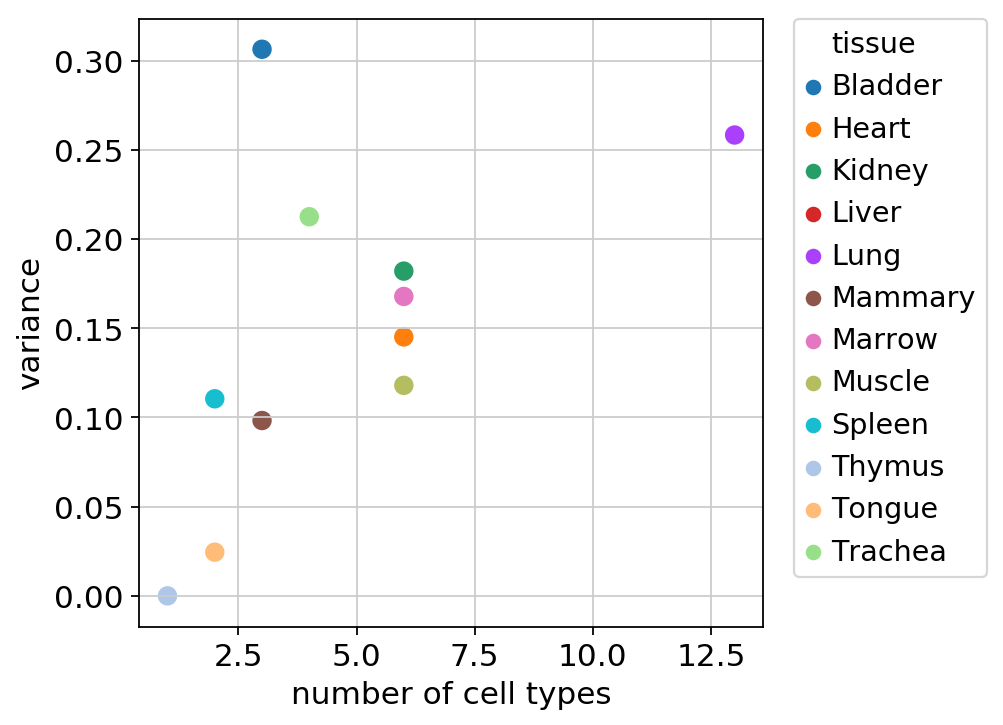

In [50]:
plt.figure(figsize=[5,5])
ax = plt.subplot(111)

sns.scatterplot(x='number of cell types',y='variance',hue='tissue',data=pearson_var_DE_df,s=90)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [51]:
distances_10X_DE_pearson = []
distances_SS2_DE_pearson = []
for tissue in tissues:
    curr_dimension = all_df_DE_pearson[tissue+'_10X'].shape[0] # common for 10X and SS2
    curr_list_10X_DE = (all_df_DE_pearson[tissue+'_10X'].to_numpy()).ravel().tolist()
    curr_list_SS2_DE = (all_df_DE_pearson[tissue+'_SS2'].to_numpy()).ravel().tolist()    
    for j in range(curr_dimension):
        # skipping the diagonal elements, because they are all 0.0 (same cell types)
        distances_10X_DE_pearson.append(curr_list_10X_DE[j*curr_dimension+j+1:j*curr_dimension+curr_dimension])
        distances_SS2_DE_pearson.append(curr_list_SS2_DE[j*curr_dimension+j+1:j*curr_dimension+curr_dimension])
# flattening the lists of lists
distances_10X_DE_pearson = [item for sublist in distances_10X_DE_pearson for item in sublist]
distances_SS2_DE_pearson = [item for sublist in distances_SS2_DE_pearson for item in sublist]
distances_df_DE_pearson = pd.DataFrame(data={'distances': distances_10X_DE_pearson+distances_SS2_DE_pearson, 
                                  'scTECH': ['10X']*len(distances_10X_DE_pearson)+['SS2']*len(distances_SS2_DE_pearson)})

In [52]:
# common array of distances for 10X and SS2, EMD
dict_tissue_to_unique_distances_DE_pearson = {}
for tissue in tissues:
    curr_dimension = all_df_DE_pearson[tissue+'_10X'].shape[0] # common for 10X and SS2
    #print(curr_dimension-2)
    if curr_dimension > 1:
        dict_tissue_to_unique_distances_DE_pearson[tissue] = factorial(curr_dimension)/(factorial(2)*factorial(curr_dimension-2))
df_tissue_to_unique_distances_DE_pearson = pd.DataFrame(index=list(dict_tissue_to_unique_distances_DE_pearson.keys()))
df_tissue_to_unique_distances_DE_pearson['unique distances'] = list(dict_tissue_to_unique_distances_DE_pearson.values())
# adding a tissue column
tissue_list_to_add_DE_pearson = [[df_tissue_to_unique_distances_DE_pearson.index[i]]*int(df_tissue_to_unique_distances_DE_pearson['unique distances'][i]) for i in range(len(df_tissue_to_unique_distances_DE_pearson))]
# flattening the list of lists
tissue_list_to_add_DE_pearson = [item for sublist in tissue_list_to_add_DE_pearson for item in sublist]
distances_df_DE_pearson['tissue'] = tissue_list_to_add_DE_pearson*2
distances_coll_DE_pearson = pd.DataFrame(data={'tissue':distances_df_DE_pearson['tissue'][:int(len(distances_df_DE_pearson)/2)],
                                    'distances 10X':distances_10X_DE_pearson,'distances SS2':distances_SS2_DE_pearson})

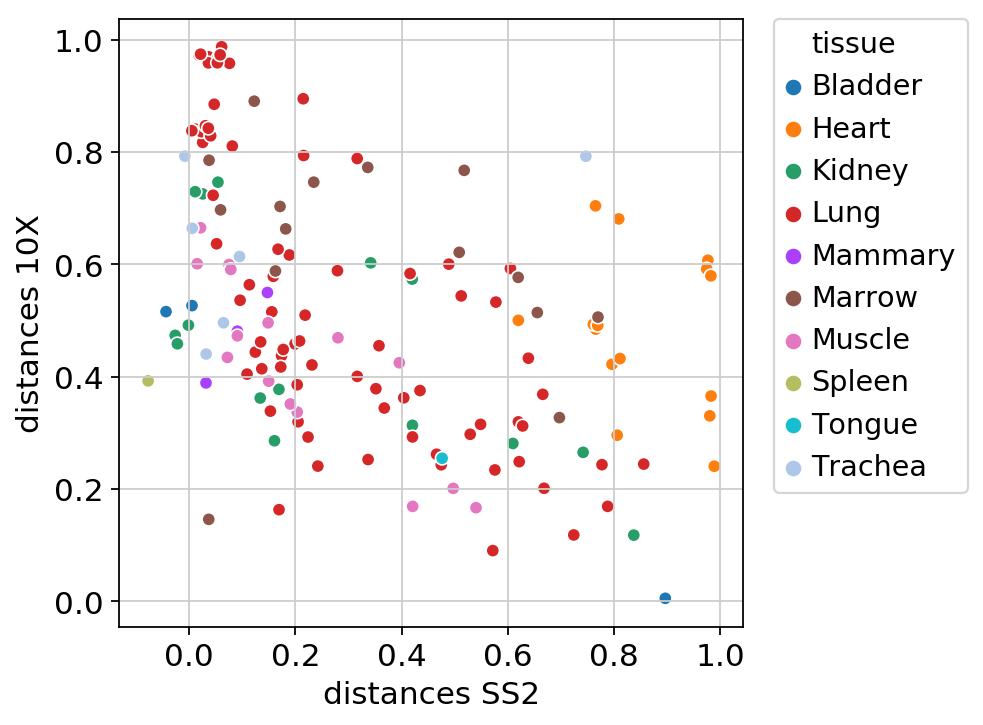

In [53]:
plt.figure(figsize=[5,5])
ax = plt.subplot(111)

sns.scatterplot(x='distances SS2',y='distances 10X',data=distances_coll_DE_pearson,hue='tissue')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [54]:
np.corrcoef(distances_coll_DE_pearson['distances 10X'],distances_coll_DE_pearson['distances SS2'])[0][1]

-0.47594590528245245

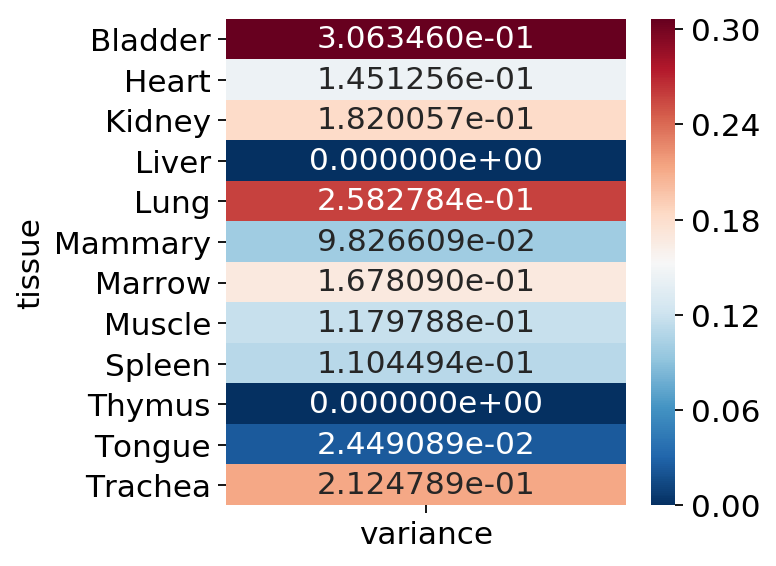

In [43]:
pearson_var_DE_df.drop(['number of cell types'],axis=1,inplace=True)
pearson_var_DE_df.set_index('tissue',inplace=True)
sns.heatmap(pearson_var_DE_df,cmap="RdBu_r",annot=True,fmt="e")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

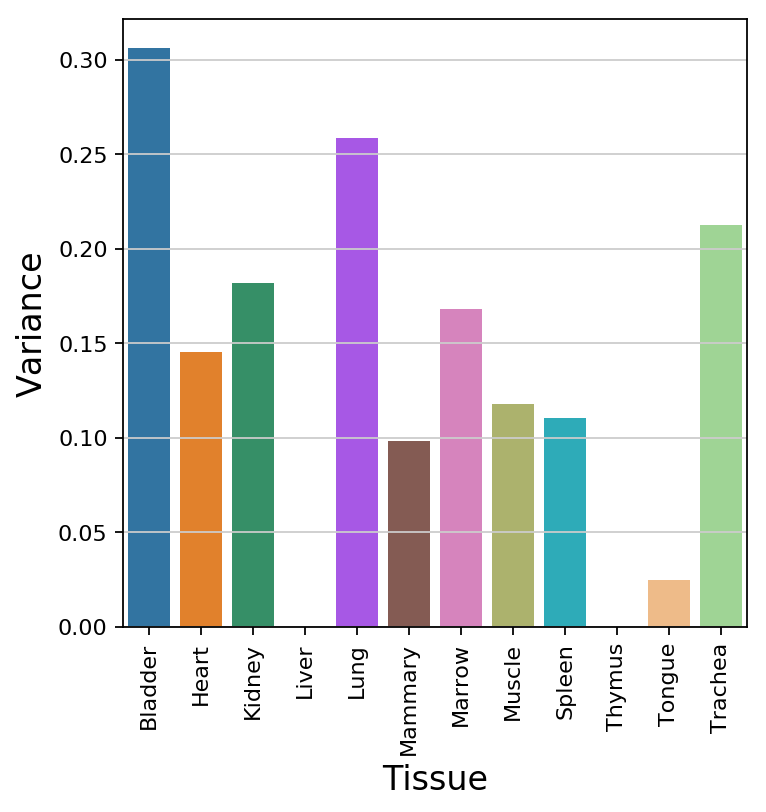

In [55]:
# just a bar chart of variances, Pearson's correlation
plt.figure(figsize=[5,5])
ax = plt.subplot(111)
sns.barplot(x=list(pearson_var_DE.keys()),y=list(pearson_var_DE.values()))
plt.xlabel('Tissue',fontsize=15)
plt.tick_params(labelsize=10)
plt.ylabel('Variance',fontsize=15)
plt.xticks(rotation='vertical')

## Creating trees from distance matrices (ignore)

In [260]:
from Bio import Phylo
from Bio.Phylo import TreeConstruction
from Bio.Phylo.TreeConstruction import DistanceMatrix

In [264]:
# creating diagonal matrices
dist_matrices = {}
for tissue in tissues:
    dist_matrices[tissue+'_10X'] = [list(all_df_DE_cosine[tissue+'_10X'].values[i][:i+1]) for i in range(len(all_df_DE_cosine[tissue+'_10X']))]
    dist_matrices[tissue+'_SS2'] = [list(all_df_DE_cosine[tissue+'_SS2'].values[i][:i+1]) for i in range(len(all_df_DE_cosine[tissue+'_SS2']))]


In [265]:
# creating DistanceMatrix objects
for tissue in tissues:
    dist_matrices[tissue+'_10X'] = DistanceMatrix(names=list(all_df_DE_cosine[tissue+'_10X'].columns),
                                                   matrix=dist_matrices[tissue+'_10X'])
    dist_matrices[tissue+'_SS2'] = DistanceMatrix(names=list(all_df_DE_cosine[tissue+'_SS2'].columns),
                                                   matrix=dist_matrices[tissue+'_SS2'])


In [286]:
# building trees
constructor = DistanceTreeConstructor()
trees = {}
for tissue in tissues:
    # common for 10X and SS2; because of common sense I guess?
    if len(list(all_df_DE_cosine[tissue+'_10X'].columns)) > 2:
        trees[tissue+'_10X'] = constructor.nj(dist_matrices[tissue+'_10X'])
        trees[tissue+'_SS2'] = constructor.nj(dist_matrices[tissue+'_SS2'])


In [288]:
Phylo.draw_ascii(tree)

   ______ fibroblast
  |
 ,|       ______________________________ fenestrated cell
 ||    __|
 ||___|  |___________________________ endothelial cell
 |    |
_|    |___________________________________________ leukocyte
 |
 |______ kidney tubule cell
 |
 |_________________________ kidney collecting duct cell



In [192]:
Phylo.write(tree, '/home/jovyan/notebooks/Tree_of_Cells/Lung_tree_trial.nw', 'newick')

1

In [194]:
tree = Phylo.read('/home/jovyan/notebooks/Tree_of_Cells/Lung_tree_trial.nw', 'newick')
#print(tree)

In [195]:
Phylo.draw_ascii(tree)

  ________________________________________________ leukocyte
 |
 |     ________________________ monocyte
 |____|
 |    |______________________________________________ endothelial cell
 |
 | __________________________________________ type II pneumocyte
 ||
 ||  ___________________________________________ dendritic cell
 ||_|
 |  | _______ Clara cell
 |  ||
 |   |____________________________________________ B cell
_|
 |  ________________________________________________ T cell
 |,|
 |||____________________________ ciliated cell
 ||
 ||______________________________________________________ stromal cell
 |
 |   _________________ mesothelial cell
 | _|
 || |___________________________________________________ natural killer cell
  |
  |____________________________________________________ macrophage



In [224]:
import ete3
from ete3 import Tree, TreeStyle

ImportError: cannot import name 'TreeStyle' from 'ete3' (/opt/conda/lib/python3.7/site-packages/ete3/__init__.py)

In [222]:
ete3.__file__

'/opt/conda/lib/python3.7/site-packages/ete3/__init__.py'

In [217]:
t = Tree("/home/jovyan/notebooks/Tree_of_Cells/Lung_tree_trial.nw", format=1)

In [216]:
import PyQt5

In [218]:
t.show()

ImportError: cannot import name 'TreeStyle' from 'ete3' (/opt/conda/lib/python3.7/site-packages/ete3/__init__.py)

In [219]:
from treelib import Node, Tree


In [220]:
treelibtree = Tree("/home/jovyan/notebooks/Tree_of_Cells/Lung_tree_trial.nw")

AttributeError: 'str' object has no attribute 'root'

In [10]:
table_stats = pd.read_csv('/home/jovyan/notebooks/Tree_of_Cells/trees_stats.csv',sep=',')

In [21]:
table_stats.columns = table_stats.columns[0:3].append('Δ')

TypeError: all inputs must be Index

In [25]:
table_stats.rename(index=str, columns={"_*": "Δ"},inplace=True)

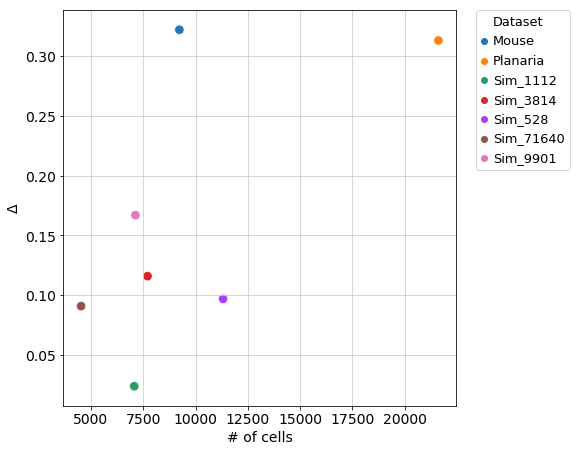

In [26]:
plt.figure(figsize=[7,7])
ax = plt.subplot(111)

sns.scatterplot(x='# of cells',y='Δ',hue='Dataset',data=table_stats,s=90)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

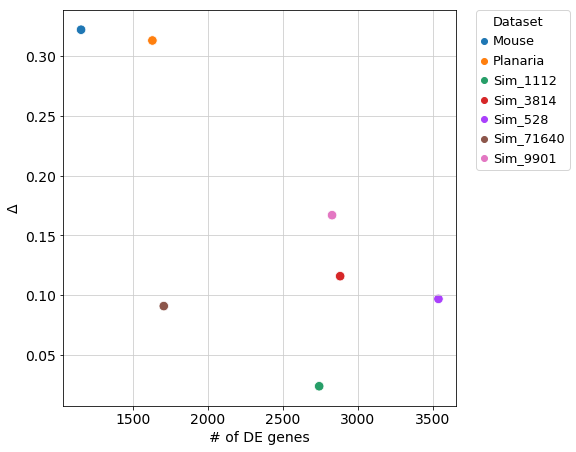

In [27]:
plt.figure(figsize=[7,7])
ax = plt.subplot(111)

sns.scatterplot(x='# of DE genes',y='Δ',hue='Dataset',data=table_stats,s=90)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)